In [1]:
import netCDF4 as nc
import scipy.io as sio
import os,sys,fnmatch,time
from scipy import interpolate
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import cmocean as cmo

from salishsea_tools.nc_tools import scDataset
from salishsea_tools import geo_tools

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

(cmapmc, norm) = functions_plot.Colormap()
from matplotlib.colors import ListedColormap
cmapmc_r = ListedColormap(cmapmc.colors[::-1])
from matplotlib.colors import LinearSegmentedColormap
colour_list = ["#c8274c","#f25546","#F06543","#e96e33",
               "#f0b038","#FFE74C","#69b944","#72b286",
               "#69b0bc","#619ee4","#4b5bbb"][::-1]
cmapIAM = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

# Observations (coordinates, salinity, temperature)

In [2]:
data = sio.loadmat('./MackenzieTransects.mat')

struct_north = data['stn']
struct_south = data['sts']

dtype_north = struct_north.dtype
dtype_south = struct_south.dtype

data_north = {n: struct_north[n][0, 0] for n in dtype_north.names}
data_south = {n: struct_south[n][0, 0] for n in dtype_south.names}

obs_dist_s = data_south['dist'][0,:]
obs_lat_s = data_south['latx'][0,:]
obs_lon_s = data_south['lonx'][0,:]
obs_temp_s = ma.masked_invalid(data_south['temp'])
obs_salt_s = ma.masked_invalid(data_south['sal'])
obs_dep_s = data_south['z'][:,0]

obs_dist_n = data_north['dist'][0,:]
obs_lat_n = data_north['latx'][0,:]
obs_lon_n = data_north['lonx'][0,:]
obs_temp_n = ma.masked_invalid(data_north['temp'])
obs_salt_n = ma.masked_invalid(data_north['sal'])
obs_dep_n = data_north['z'][:,0]

# Model (coordinates)

In [3]:
def get_coords(dirname):
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    nav_lat = nc.Dataset(dirname)['nav_lat'][y, x]
    nav_lon = nc.Dataset(dirname)['nav_lon'][y, x]
    real = nc.Dataset(dirname)['Bathymetry'][y, x]

    return nav_lat, nav_lon, real

In [4]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/runs_with_ts/real_base/1_real_bathy_for_agrif_fix.nc'
nav_lat, nav_lon, real = get_coords(dirname)

In [9]:
def get_closest_coords(obs_lon_x, obs_lat_x, nav_lon, nav_lat):

    j_full = np.full(len(obs_lon_x), np.nan)
    i_full = np.full_like(j_full, np.nan)
    mod_lon_full = np.full_like(j_full, np.nan)
    mod_lat_full = np.full_like(j_full, np.nan)

    for n in range(len(obs_lon_x)):

        j, i = geo_tools.find_closest_model_point(obs_lon_x[n], obs_lat_x[n], nav_lon, nav_lat,
                                                  grid='MCKNZ', land_mask=None,
                                                  tols={'MCKNZ': {'tol_lon': 0.02, 'tol_lat': 0.02}})

        j_full[n] = j
        i_full[n] = i
        mod_lon_full[n] = nav_lon[j, i]
        mod_lat_full[n] = nav_lat[j, i]

    return j_full, i_full, mod_lon_full, mod_lat_full

# Closest points

In [10]:
j_s, i_s, mod_lon_s, mod_lat_s = get_closest_coords(obs_lon_s, obs_lat_s, nav_lon, nav_lat)
j_n, i_n, mod_lon_n, mod_lat_n = get_closest_coords(obs_lon_n, obs_lat_n, nav_lon, nav_lat)

In [11]:
def plot_map(fig, ax, x, y, z, cmap, nav_lon, nav_lat, real):
    p = ax.pcolormesh(x, y, z, cmap=cmapmc, vmin=-1600, vmax=1000)
    CS = ax.contour(nav_lon, nav_lat, real, levels = np.arange(0, 500, 20), colors='k', linestyle='-', alpha=0.5)
    for line in CS.collections:
        if line.get_linestyle() == [(None, None)]:
            pass
        else:
            line.set_linestyle([(None, None)])
            line.set_color('k')
    ax.clabel(CS, fmt='%1.1f')
    #fig.colorbar(p, ax=ax)
    ax.legend(loc=2, fontsize=20)
    ax.set_xlim([-141, -136])
    ax.set_ylim([69.5, 70.5])
    w=1/math.cos(math.radians(70.0))
    ax.set_aspect(w)
    ax.set_ylabel('latitude [$^o$]', fontsize=20)
    ax.set_xlabel('longitude [$^o$]', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    fig.tight_layout()
    return fig, ax

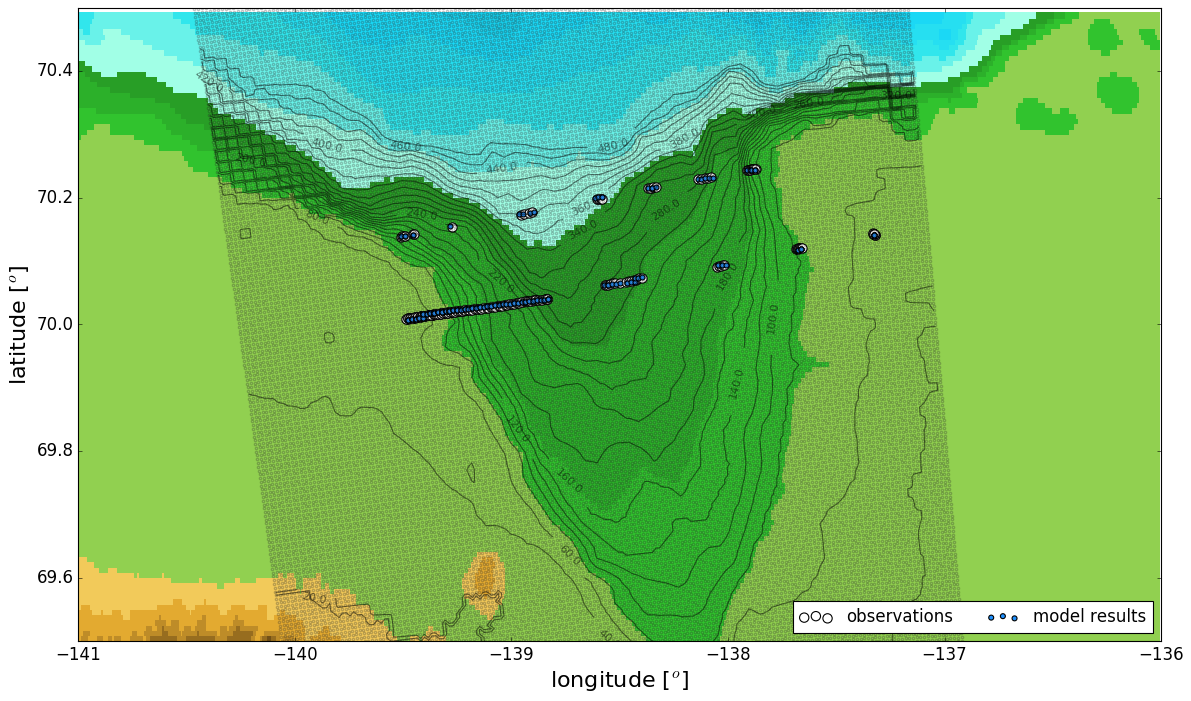

In [12]:
x, y, z = functions_plot.def_regionG(xl=-141, xr=-136, yb=69.5, yt=70.5)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

fig, ax = plot_map(fig, ax, x, y, z, cmapmc_r, nav_lon, nav_lat, real)

ax.scatter(obs_lon_s, obs_lat_s, c='w', s=70, edgecolors='k')
ax.scatter(obs_lon_n, obs_lat_n, c='w', s=70, edgecolors='k', label='observations')

ax.scatter(mod_lon_s, mod_lat_s, s=20, edgecolors='k', c='dodgerblue')
ax.scatter(mod_lon_n, mod_lat_n, s=20, edgecolors='k', c='dodgerblue', label='model results')

ax.scatter(nav_lon, nav_lat, s=5, edgecolors='k', c='gray', alpha=0.2)

ax.legend(ncol=2, loc=4, fontsize=15)

# Salinity/Temperature at closest points

https://stackoverflow.com/questions/23301231/how-to-append-masked-arrays

In [13]:
def get_vars(dirname, j, i, time_start, time_end, var):
        
    fname = "1_MCKNZ_1h_20170101_201701*"
    y,x = int(j+1), int(i+1)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
            
    with scDataset(filesT) as dsT:
        deptht = dsT.variables['deptht'][:]
        var_array0 = dsT.variables[var][time_start:time_end, :, y, x]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, :, y, x]
        
    tmask = np.tile(tmask0, (len(var_array0), 1))  
    var_array = np.ma.array(var_array0, mask=1 - tmask)
    
    var_mean = np.mean(var_array, axis=0)
    
    return var_array, var_mean, deptht, tmask

In [14]:
def masked_stack(tup):
    return np.ma.masked_array(np.vstack(tup), mask=np.vstack([arr.mask for arr in tup]))

In [15]:
def get_vars_stations(dirname, j_full, i_full, time_start, time_end, var_name):
    
    for n in range(len(j_full)):

        j, i = int(j_full[n]), int(i_full[n])
        
        if var_name == 'salinity':
            var_array, var_mean, deptht, tmask = get_vars(dirname, j, i, time_start, time_end, 'vosaline')
        elif var_name == 'temperature':
            var_array, var_mean, deptht, tmask = get_vars(dirname, j, i, time_start, time_end, 'votemper')
            
        if n == 0:
            var_mean_stations0 = var_mean
        else:
            var_mean_stations0 = masked_stack((var_mean_stations0, var_mean))
            
    var_mean_stations = np.transpose(var_mean_stations0)
        
    return var_mean_stations, deptht

In [16]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/runs_with_ts/real_base/'
time_start, time_end = 24*3, 24*4

salt_mean_stations_n, deptht = get_vars_stations(dirname, j_n, i_n, time_start, time_end, 'salinity')
salt_mean_stations_s, deptht = get_vars_stations(dirname, j_s, i_s, time_start, time_end, 'salinity')

temp_mean_stations_n, deptht = get_vars_stations(dirname, j_n, i_n, time_start, time_end, 'temperature')
temp_mean_stations_s, deptht = get_vars_stations(dirname, j_s, i_s, time_start, time_end, 'temperature')

In [18]:
mod_salt_n = salt_mean_stations_n
mod_salt_s = salt_mean_stations_s
mod_temp_n = temp_mean_stations_n
mod_temp_s = temp_mean_stations_s

In [19]:
mod_salt_n.shape, mod_salt_s.shape

((80, 35), (80, 222))

# Figures showing salinity/temperature cross-sections

In [55]:
def plot_crosscanyon_panels(fig, ax, dist, dep, var, num, vmin, vmax, var_name, transect_name, mod_or_obs):
    cmap = plt.get_cmap(cmapIAM)
    cmap.set_bad('silver')
    
    if num == None:
        p = ax.pcolormesh(dist, dep, var, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xlim([dist.min(), dist.max()])
        ttl_add = ''
    else:
        f = interpolate.interp1d(dist, var)
        dist_new = np.linspace(dist[0], dist[-1], num=num)
        var_new = f(dist_new)
        var_new = ma.masked_invalid(var_new)
        p = ax.pcolormesh(dist_new, dep, var_new, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xlim([dist_new.min(), dist_new.max()])
        ttl_add = ' (interpolated)'
        
    #ax.set_ylim([np.nanmax(dep), np.nanmin(dep)])
    ax.set_xlabel('distance', fontsize=20)
    ax.set_ylabel('depth [m]', fontsize=20)
    fig.colorbar(p, ax=ax)
    ax.set_title(var_name + ': '+mod_or_obs + ' ('+transect_name+' stations)' + ttl_add, fontsize=20)
    return ax

In [60]:
def plot_crosscanyon_story(x, y, z, nav_lon, nav_lat, real,
                           obs_lon_n, obs_lat_n, obs_lon_s, obs_lat_s,
                           mod_lon_n, mod_lat_n, mod_lon_s, mod_lat_s,
                           obs_dist_n, obs_dist_s, obs_dep_n, obs_dep_s, deptht,
                           obs_var_n, obs_var_s, mod_var_n, mod_var_s, var_name):
    
    if var_name == 'salinity':
        vmin, vmax = 29, 34
    elif var_name == 'temperature':
        vmin, vmax = -1.5, 4
    
    fig = plt.figure(figsize=(20, 20))
    ax = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((3, 2), (1, 0))
    ax2 = plt.subplot2grid((3, 2), (1, 1))
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))

    # ---------------------------------------------------------------------
    
    fig, ax = plot_map(fig, ax, x, y, z, cmapmc_r, nav_lon, nav_lat, real)

    ax.scatter(obs_lon_n, obs_lat_n, c='w', s=70, edgecolors='k', label='observations')
    ax.scatter(obs_lon_s, obs_lat_s, c='w', s=70, edgecolors='k')

    ax.scatter(mod_lon_n, mod_lat_n, s=20, edgecolors='k', c='dodgerblue', label='model results')
    ax.scatter(mod_lon_s, mod_lat_s, s=20, edgecolors='k', c='dodgerblue')

    ax.legend(ncol=2, loc=4, fontsize=15)
    ax.set_title('Model bathymetry with north and south observation stations', fontsize=20)
    
    # ---------------------------------------------------------------------
    
    ax1 = plot_crosscanyon_panels(fig, ax1, obs_dist_n, obs_dep_n, obs_var_n, None, vmin, vmax,
                                  var_name, 'north', 'observations')
    ax2 = plot_crosscanyon_panels(fig, ax2, obs_dist_n, deptht, mod_var_n, None, vmin, vmax,
                                  var_name, 'north', 'model')
    
    # ---------------------------------------------------------------------
    
    ax3 = plot_crosscanyon_panels(fig, ax3, obs_dist_s, obs_dep_s, obs_var_s, None, vmin, vmax,
                                  var_name, 'south', 'observations')
    ax4 = plot_crosscanyon_panels(fig, ax4, obs_dist_s, deptht, mod_var_s, None, vmin, vmax,
                                  var_name, 'south', 'model')
    
    # ---------------------------------------------------------------------
    
    for ax, n in zip([ax1, ax2, ax3, ax4], np.arange(4)):
        ax.set_ylim([np.nanmax(obs_dep_n), 0])
               
    fig.tight_layout(w_pad=0.2)
    return fig

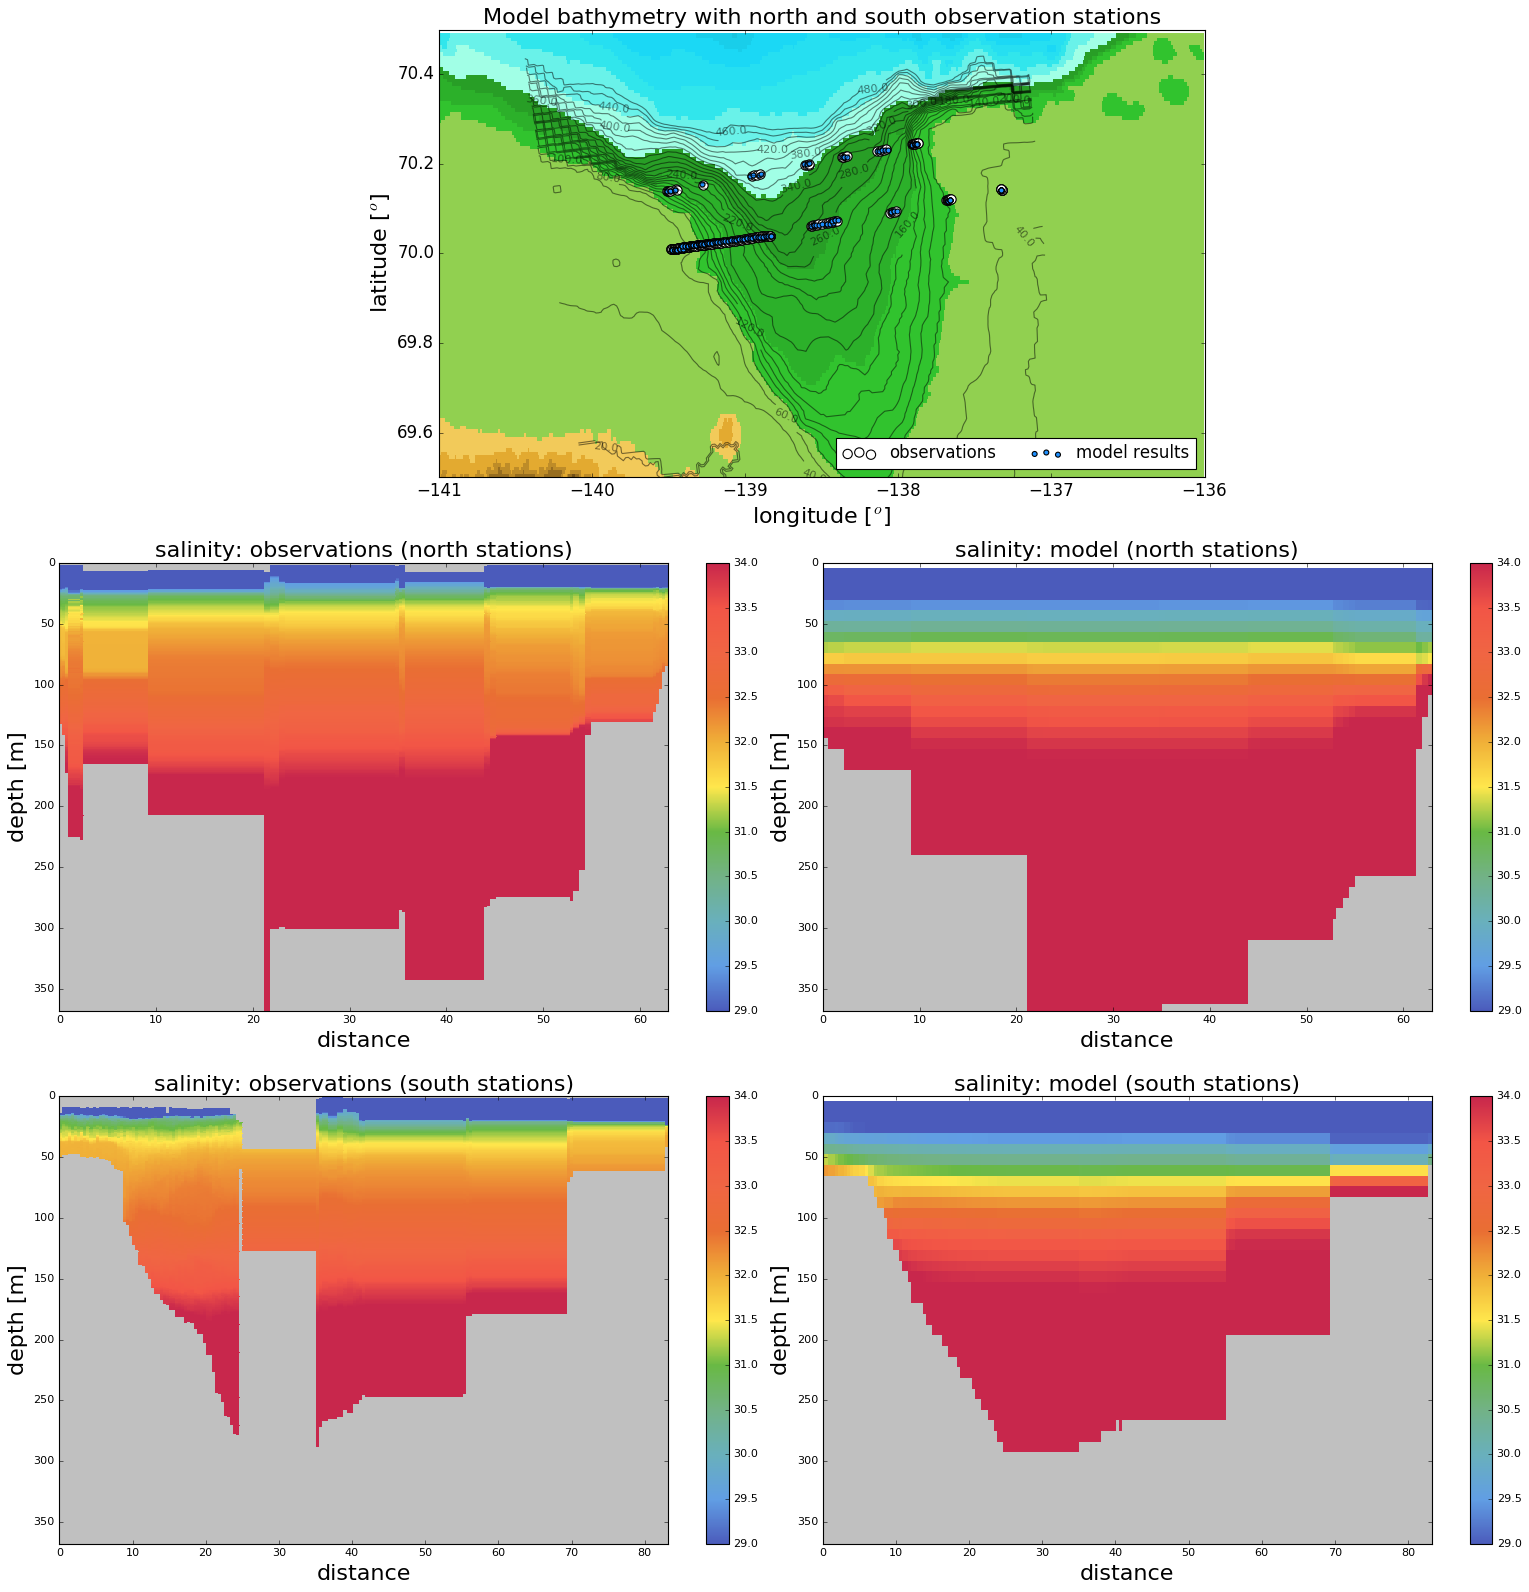

In [61]:
fig = plot_crosscanyon_story(x, y, z, nav_lon, nav_lat, real,
                           obs_lon_n, obs_lat_n, obs_lon_s, obs_lat_s,
                           mod_lon_n, mod_lat_n, mod_lon_s, mod_lat_s,
                           obs_dist_n, obs_dist_s, obs_dep_n, obs_dep_s, deptht,
                           obs_salt_n, obs_salt_s, mod_salt_n, mod_salt_s, 'salinity')

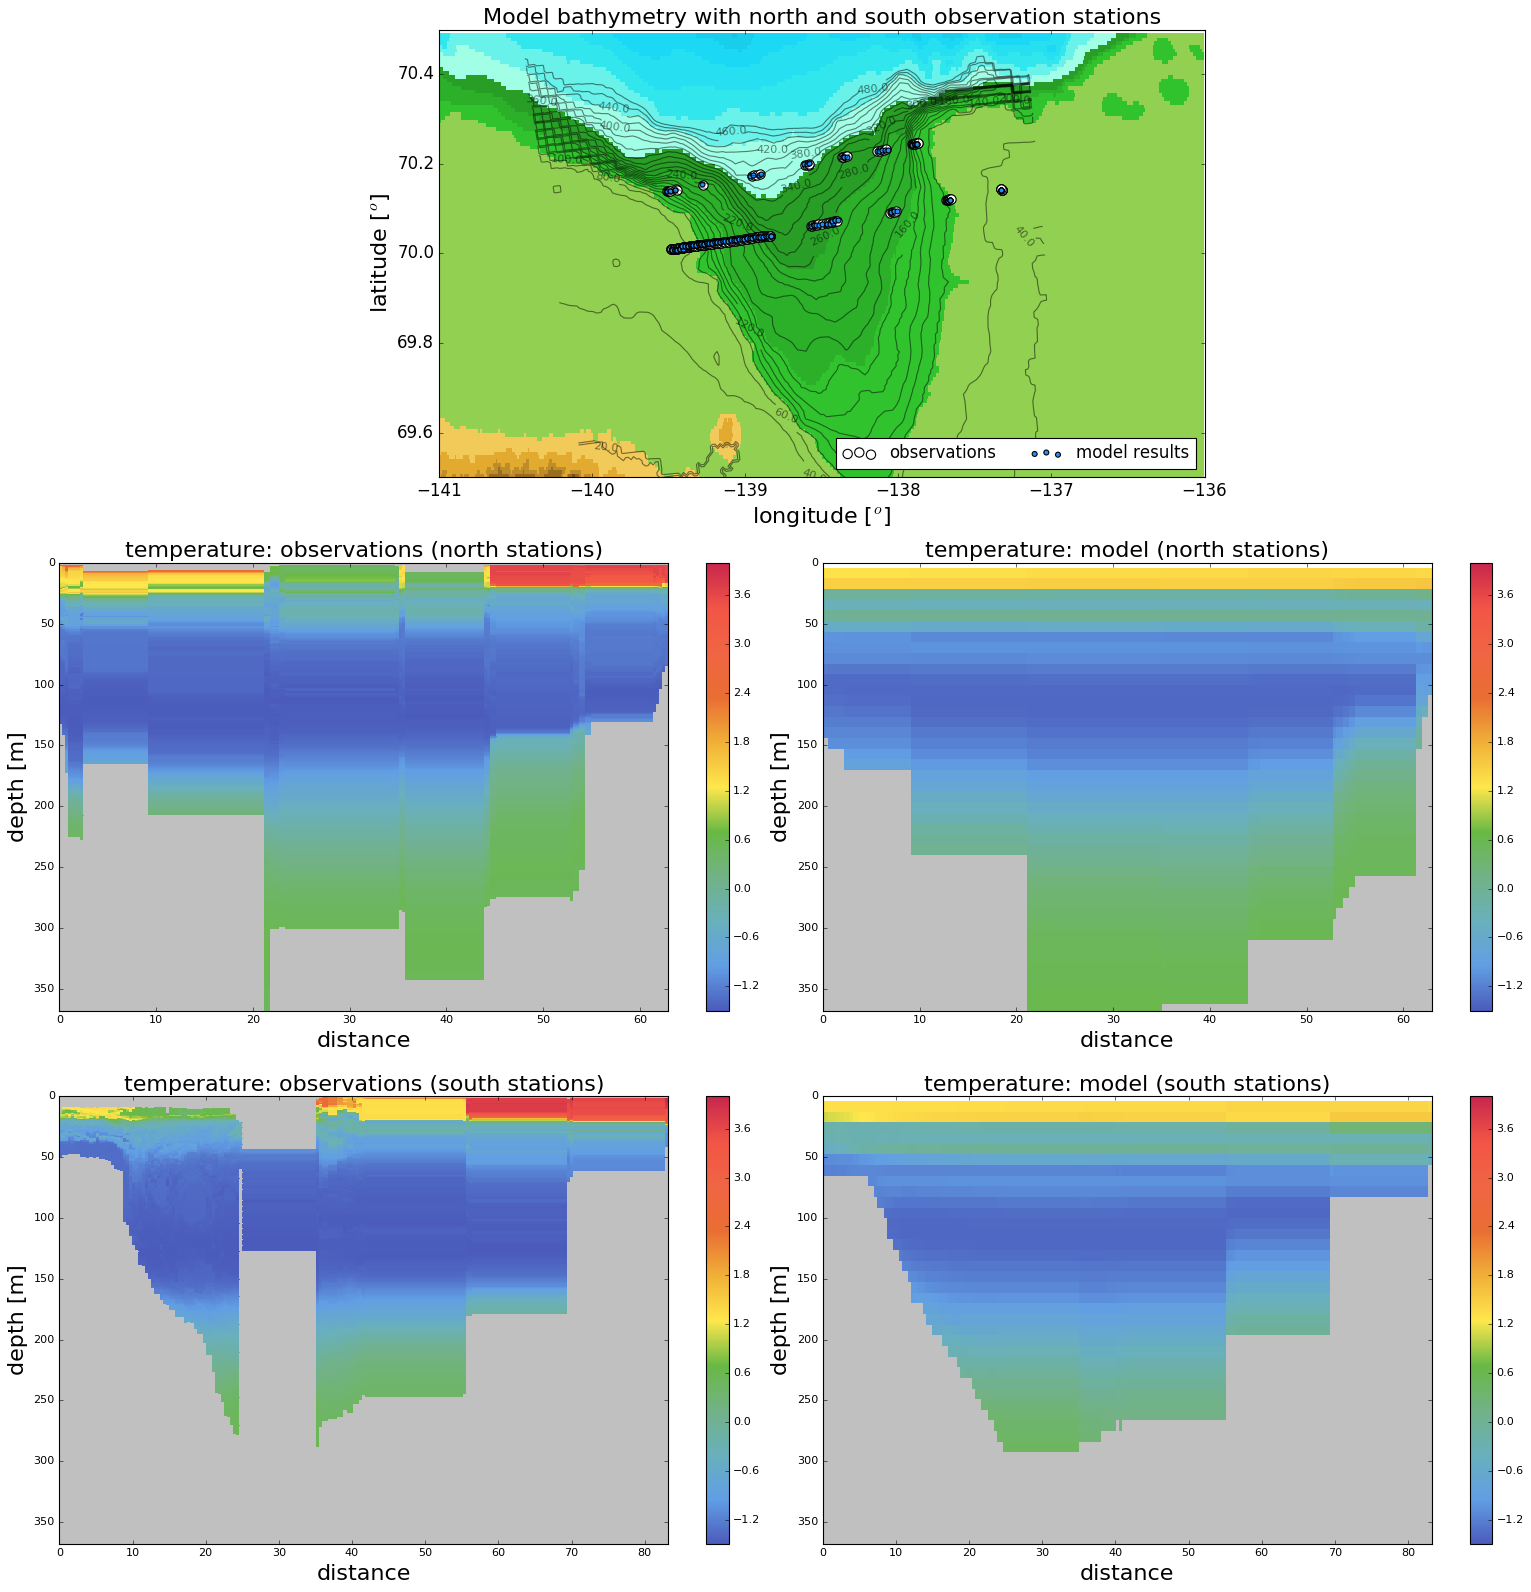

In [62]:
fig = plot_crosscanyon_story(x, y, z, nav_lon, nav_lat, real,
                           obs_lon_n, obs_lat_n, obs_lon_s, obs_lat_s,
                           mod_lon_n, mod_lat_n, mod_lon_s, mod_lat_s,
                           obs_dist_n, obs_dist_s, obs_dep_n, obs_dep_s, deptht,
                           obs_temp_n, obs_temp_s, mod_temp_n, mod_temp_s, 'temperature')